In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy import stats
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE 

In [52]:
filename = "properties.csv"
df = pd.read_csv(filename)


In [53]:
# Identify columns with more than 10000 missing values and drop them
missing_values_count = df.isnull().sum()
columns_with_many_missing = missing_values_count[missing_values_count > 10000]
df.drop(columns=columns_with_many_missing.index, inplace=True)

df.drop(['id'], axis=1, inplace=True)

df.drop_duplicates(inplace=True)

df.dropna(inplace=True)


In [ ]:
# Check for categorical variables and numerical variables
obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (df.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (df.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 9
Integer variables: 8
Float variables: 4


In [55]:
df.columns

Index(['price', 'property_type', 'subproperty_type', 'region', 'province',
       'locality', 'zip_code', 'total_area_sqm', 'nbr_bedrooms',
       'equipped_kitchen', 'fl_furnished', 'fl_open_fire', 'fl_terrace',
       'fl_garden', 'garden_sqm', 'fl_swimming_pool', 'fl_floodzone',
       'state_building', 'epc', 'heating_type', 'fl_double_glazing'],
      dtype='object')

In [56]:
# Defining the target (price) and features by dropping irrelevant columns
target = df['price']
features = df.drop(columns=['price'])
# One-Hot Encoding for Categorical Features
# Using OneHotEncoder to transform categorical variables in features
categorical_features = features.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical_data = encoder.fit_transform(features[categorical_features])
encoded_categorical_df = pd.DataFrame(
    encoded_categorical_data, 
    columns=encoder.get_feature_names_out(categorical_features),
    index=features.index
)
# Removing original categorical columns and adding encoded ones
features_encoded = features.drop(columns=categorical_features).join(encoded_categorical_df)

In [57]:
obj = (features_encoded.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (features_encoded.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (features_encoded.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 0
Integer variables: 8
Float variables: 113


In [58]:
features_encoded.shape

(63927, 121)

In [59]:
features_encoded.columns

Index(['zip_code', 'total_area_sqm', 'nbr_bedrooms', 'fl_furnished',
       'fl_open_fire', 'fl_terrace', 'fl_garden', 'garden_sqm',
       'fl_swimming_pool', 'fl_floodzone',
       ...
       'epc_F', 'epc_G', 'epc_MISSING', 'heating_type_ELECTRIC',
       'heating_type_FUELOIL', 'heating_type_GAS', 'heating_type_MISSING',
       'heating_type_PELLET', 'heating_type_SOLAR', 'heating_type_WOOD'],
      dtype='object', length=121)

In [60]:
#MODELS

In [61]:
# Feature Scaling for Numerical Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_encoded)
features_scaled = pd.DataFrame(scaled_features, columns=features_encoded.columns, index=features_encoded.index)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Displaying shapes to confirm preprocessing steps
(X_train.shape, X_test.shape), y_train.shape, y_test.shape

(((51141, 121), (12786, 121)), (51141,), (12786,))

In [62]:
#The top 10 features most correlated with price are:
# Adding the target column back temporarily for correlation analysis
correlation_df = features_scaled.copy()
correlation_df['price'] = target

# Calculating the correlation matrix
correlation_matrix = correlation_df.corr()

# Sorting features by their absolute correlation with price, excluding 'price' itself
price_correlation = correlation_matrix['price'].drop('price').abs().sort_values(ascending=False)

# Displaying the top 10 features most correlated with price
top_10_correlated_features = price_correlation.head(10)
top_10_correlated_features


nbr_bedrooms                             0.384921
locality_Brugge                          0.248734
subproperty_type_VILLA                   0.222633
fl_swimming_pool                         0.204588
total_area_sqm                           0.195832
region_Wallonia                          0.155950
subproperty_type_EXCEPTIONAL_PROPERTY    0.146561
property_type_HOUSE                      0.126416
province_West Flanders                   0.124242
equipped_kitchen_USA_HYPER_EQUIPPED      0.120234
Name: price, dtype: float64

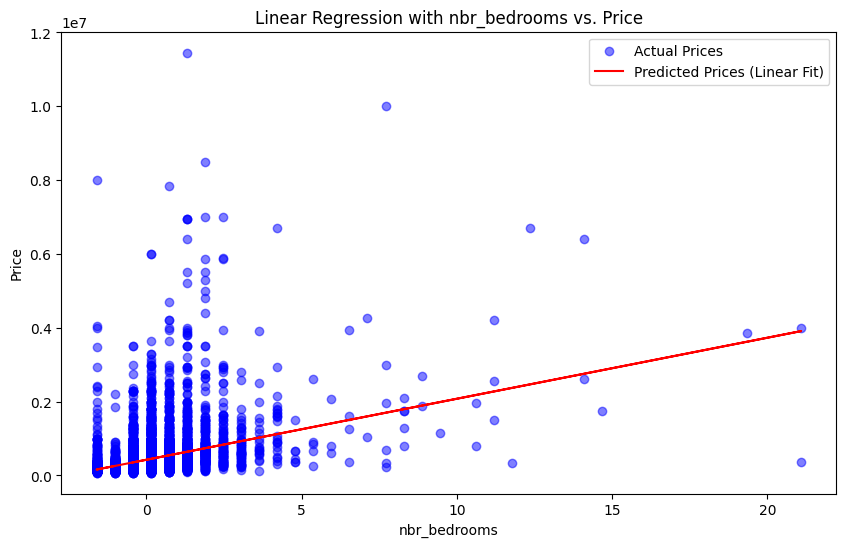

In [63]:
# Choosing the feature with the highest correlation with price for single linear regression visualization
feature_name = top_10_correlated_features.index[0]
X_train_feature = X_train[feature_name].values.reshape(-1, 1)

# Re-fitting the model with a single feature for visualization purposes
single_feature_model = LinearRegression()
single_feature_model.fit(X_train_feature, y_train)

# Predicting based on the single feature in the test set
X_test_feature = X_test[feature_name].values.reshape(-1, 1)
y_pred_single = single_feature_model.predict(X_test_feature)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test[feature_name], y_test, color="blue", label="Actual Prices", alpha=0.5)
plt.plot(X_test[feature_name], y_pred_single, color="red", label="Predicted Prices (Linear Fit)")
plt.xlabel(feature_name)
plt.ylabel("Price")
plt.title(f"Linear Regression with {feature_name} vs. Price")
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error, r2_score

# Initializing and training the Linear Regression model with all selected features
multiple_linear_model = LinearRegression()
multiple_linear_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_multiple = multiple_linear_model.predict(X_test)

# Calculating metrics for evaluation
mse_multiple = mean_squared_error(y_test, y_pred_multiple)
r2_multiple = r2_score(y_test, y_pred_multiple)

mse_multiple, r2_multiple

(np.float64(138452004524.79395), 0.3644359031195179)

In [65]:
# Initialize the XGBoost Regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training set
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgboost = xgboost_model.predict(X_test)


# Calculate evaluation metrics
mse_xgboost = mean_squared_error(y_test, y_pred_xgboost)
r2_xgboost = r2_score(y_test, y_pred_xgboost)

# Print the evaluation metrics
print(f"XGBoost Mean Squared Error: {mse_xgboost}")
print(f"XGBoost R-squared: {r2_xgboost}")


XGBoost Mean Squared Error: 61937082122.98474
XGBoost R-squared: 0.7156777484152815


In [ ]:
#SVM – Support vector Machine
model_SVR = svm.SVR()
model_SVR.fit(X_train, y_train)
y_pred = model_SVR.predict(X_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

In [82]:
#Linear Regression
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)

print(mean_absolute_percentage_error(y_test, y_pred))

print(r2_score(y_test, y_pred))

0.3926466897876438
0.3644359031195179


In [68]:
#Random Forest Regression

In [69]:
X = features_encoded.iloc[:,1:2].values  #features
y = features_encoded.iloc[:,2].values  # Target variable

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

#Check for and handle categorical variables
label_encoder = LabelEncoder()
x_categorical = features_encoded.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = features_encoded.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(x, y)

c:\Users\Linh Tran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [70]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the same data or new data
predictions = regressor.predict(x)

# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.9347961572182087
Mean Squared Error: 0.006980305661144743
R-squared: 0.9976366201589386


In [72]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

# Load the datasets
X = features_encoded.data[:, :2]
y = features_encoded.target

#Build the model
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(X, y)

# Plot Decision Boundary
DecisionBoundaryDisplay.from_estimator(
        svm,
        X,
        response_method="predict",
        cmap=plt.cm.Spectral,
        alpha=0.8,
        xlabel=features_encoded.feature_names[0],
        ylabel=features_encoded.feature_names[1],
    )

# Scatter plot
plt.scatter(X[:, 0], X[:, 1], 
            c=y, 
            s=20, edgecolors="k")
plt.show()


AttributeError: 'DataFrame' object has no attribute 'data'